In [59]:
import os 

import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np

from tqdm import notebook
import torch
from torch.utils.data import DataLoader
from torch.nn import functional as F
from torchvision import transforms
import torchvision
from torchvision import models, io
import plotly.express as px
from plotly import graph_objects as go
from ipywidgets import widgets, interact

mpl.rcParams["figure.figsize"] = (10, 10)

In [2]:
%load_ext autoreload

%autoreload 2

In [3]:
from face_landmarks import LandMarkDatset, SquarePaddingResize, denormalize_landmarks

In [4]:
def plot_landmarks(image_info):
    image = image_info["image"].permute(1, 2, 0)
    height, width = image.shape[:2]
    landmarks = denormalize_landmarks(image_info["norm_landmarks"], width, height) 
    plt.imshow(image)
    plt.plot(landmarks[:, 0], landmarks[:, 1], "g+", markersize=1)

In [5]:
dir_path = os.path.join("data", "test-train", "contest01_data")

In [6]:
data = LandMarkDatset(dir_path, is_train=True, transformations=None)

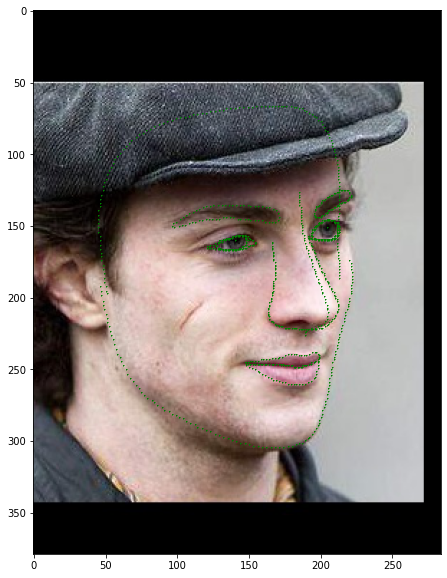

In [7]:
plot_landmarks(data[123])

In [8]:
del data

In [9]:
import pickle

In [10]:
with open(os.path.join("data", "features", "train_emb.pickle"), "rb") as file:
    features = pickle.load(file)

In [11]:
features.shape

(64000, 1024)

In [12]:
dataset = LandMarkDatset(dir_path, is_train=True, transformations=None)

In [13]:
from sklearn import ensemble
from sklearn import svm, neighbors

In [69]:
# outlier_detection = ensemble.IsolationForest(n_estimators=100, n_jobs=-1, verbose=True)
outlier_detection = ensemble.IsolationForest(n_estimators=80, verbose=1, n_jobs=-1)

In [70]:
predictions = outlier_detection.fit_predict(features)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   22.5s remaining:  1.1min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   23.4s finished


In [71]:
np.argwhere(predictions == -1).shape

(661, 1)

In [72]:
images = dataset.index2img_name(np.argwhere(predictions == -1).reshape(-1))

In [40]:
image_dir = os.path.join(dir_path, "train", "images")

In [73]:
tensor_images = []
for image_name in images:
    image_tensor = io.read_image(os.path.join(image_dir, image_name))
    image_tensor = transforms.Resize((197, 256))(image_tensor)
    tensor_images.append(image_tensor)

In [74]:
def show_image(image_index, tensor_images):
    figure = go.FigureWidget()
    figure.add_trace(go.Image(z=tensor_images[image_index].permute(1, 2, 0)))
    return figure

In [75]:
list_widget = widgets.Dropdown(options=tuple(range(len(images))))

In [76]:
interact(show_image, image_index=list_widget, tensor_images=widgets.fixed(tensor_images))

interactive(children=(Dropdown(description='image_index', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1…

<function __main__.show_image(image_index, tensor_images)>

In [77]:
import umap

In [78]:
umap = umap.UMAP(n_components=2, n_neighbors=20, metric="cosine")

In [66]:
emb = umap.fit_transform(features)

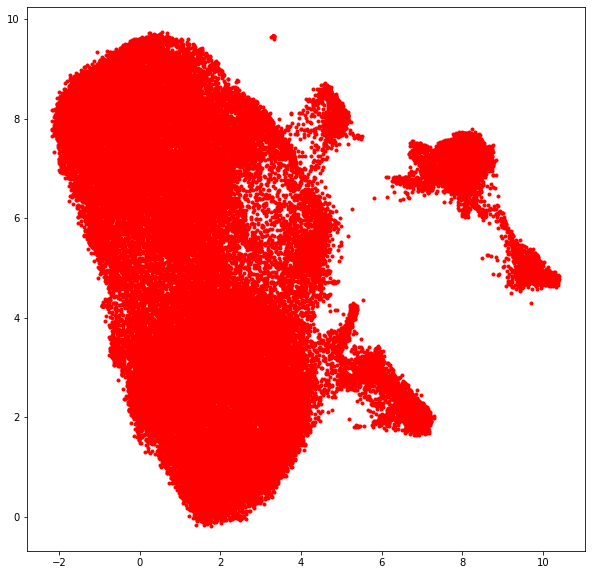

In [67]:
px.scatter(emb, colors=images)